In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

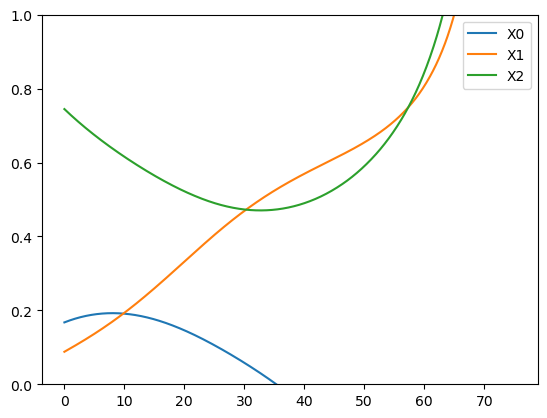

In [34]:
# define the DAE system
n = 3
alpha = np.array([0.1, 0.2, 0.1])
K = 2/3
beta = np.random.rand(n, n) * 0.01


def dae(t, X):
    dXdt = np.zeros_like(X)

    total_effect = 0
    for k in range(n):
        total_effect += X[k] * (alpha[k] * (1 - X[k] / K) - np.sum([beta[k, l] * X[l] for l in range(n) if l != k]))
    
    avg_effect = total_effect / n

    for i in range(n):
        dXdt[i] = X[i] * (alpha[i] * (1 - X[i] / K) - np.sum([beta[i, j] * X[j] for j in range(n) if j != i])) - avg_effect
    
    return dXdt


# initial conditions
X0 = np.random.rand(n) * 0.1
X0 = X0 / np.sum(X0)

# solve the DAE system
sol = solve_ivp(dae, [0, 100], X0, method='BDF', t_eval=np.linspace(0, 100, 1000))

# plot the results
plt.figure()
for i in range(n):
    plt.plot(sol.t, sol.y[i], label=f'X{i}')


plt.ylim(0, 1)
plt.legend()
plt.show()
